In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import os.path
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df1 = pd.read_csv('../data/match_old_ec109.csv')
df2 = pd.read_csv('../data/mismatch_old_ec109.csv')

In [85]:
df1.time.unique().shape[0]/125

6.008

In [3]:
def gen_wide_df(df, f_idx, t_idx):
    """

    :param df:
    :param f_idx:
    :param t_idx:
    :return:
    """
    df = df.loc[(df['time'].isin(t_idx)) & (df['freqs'].isin(f_idx))]

    # z-score within block
    gb = df.groupby(['elecs', 'freqs', 'blockno'])
    df['zpow'] = gb['pow'].apply(zscore)
    df['sin'] = gb['phase'].apply(np.sin)
    df['cos'] = gb['phase'].apply(np.cos)
    df.drop(['pow', 'phase'], inplace=True, axis=1)

    df = pd.pivot_table(df,
                        index=['class', 'blockno', 'events'],
                        columns=['elecs', 'freqs', 'time'],
                        aggfunc=[lambda x: x])

    elecs = df.columns.get_level_values('elecs')
    freqs = df.columns.get_level_values('freqs')
    time = df.columns.get_level_values('time')
    ncol = len(elecs)

    return df, elecs, freqs, time, ncol


def get_data_and_labels(df, label_key, index):

    y = df.loc[index, label_key]
    X = df.loc[index, :].drop(label_key, axis=1)

    return X,y

def zscore(x):
    z = (x - np.mean(x)) / np.std(x)
    return z

In [4]:
class Decoder(object):
    """
    This class constructs a decoder that will learn to map from multivariate neural data to the location of a fixation

    Parameters
    ---
    data_files : str
        Location of where the neural data is to be loaded (list of files per class)
    """

    def __init__(self,
                 data_files=None,
                 long_csv=None,
                 label_key='class',
                 out_dir=None,
                 freq_idx=[np.arange(4, 8), np.arange(8,15)],
                 time_idx=[np.arange(0,250,10), np.arange(250,500,10), np.arange(500,750)]):


        if data_files is None:
            data_files = ['class1.csv', 'class2.csv']
        self.data_files = data_files

        # check if the df exists, if not create it
        if long_csv is None:
            long_csv = 'long.csv'
        self.long_csv = long_csv
        if not os.path.isfile(long_csv):
            self.gen_long()

        # parameters for cross-validation
        self.test_size = 0.2
        self.shuffle = False
        self.nfold = 5

        # parameters for sklearn inputs
        self.label_key = label_key

        self.freqs = freq_idx
        self.times = time_idx

        self.out_dir = out_dir
        
    def gen_long(self):
        """
        Generates a long format CSV
        :return:
        """

        # read header on first
        df = pd.read_csv(self.data_files[0])
        df['class'] = 0

        for i, file in enumerate(self.data_files[1:]):
            df_tmp = pd.read_csv(file)
            df_tmp['class'] = i + 1
            df = pd.concat([df, df_tmp], axis=0)

        df.reset_index(drop=True, inplace=True)

        df.to_csv(self.long_csv, index=False)

In [5]:
ec109_decoder = Decoder(data_files=['/Users/drdj/locdec/data/mismatch_old_ec109.csv',
                                    '/Users/drdj/locdec/data/match_old_ec109.csv'],
                        long_csv='long.csv',
                        out_dir='/Users/drdj/locdec/data/')

In [6]:
ec109_decoder.long_csv

'long.csv'

In [7]:
C_grid = np.logspace(-10,2,20)
kf = KFold(n_splits=5, shuffle=True)

df_long = pd.read_csv(ec109_decoder.long_csv)

In [ ]:
df_long['class'].unique()
[f'class_{x}' for x in df_long['class'].unique()]

In [ ]:
for train, test in kf.split(df_long.index.get_values()):
    print('train',train)
    print('test',test)

In [33]:
for t in [np.arange(0,250,10), np.arange(250,500,10), np.arange(500,750, 10)]:
    print(t)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240]
[250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420
 430 440 450 460 470 480 490]
[500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670
 680 690 700 710 720 730 740]


In [38]:
df_long.loc[(df_long['time'].isin(np.arange(500,750))) & (df_long['freqs'].isin(np.arange(8,15)))]

,events,blockno,elecs,freqs,time,pow,phase,class
1522377,1,1,1,8,500,3.405110,2.352064,0
1522378,2,1,1,8,500,3.602217,2.187349,0
1522379,3,1,1,8,500,4.454280,-0.312351,0
1522380,4,1,1,8,500,3.693211,1.788673,0
1522381,5,1,1,8,500,3.291292,-1.162460,0
1522382,6,1,1,8,500,2.911606,1.291784,0
1522383,7,1,1,8,500,3.567197,0.050391,0
1522384,8,1,1,8,500,1.574639,-2.209393,0
1522385,9,1,1,8,500,2.787891,0.212673,0
1522386,10,1,1,8,500,3.775547,-2.194327,0


In [34]:
for f in [np.arange(4, 8)]:
    for t in [np.arange(0,250,10)]:
                # iterate over folds
        df, elecs, freqs, time, ncol = gen_wide_df(df_long, f, t)
        df.reset_index(drop=False, inplace=True)

        for train_ind, test_ind in kf.split(df):
            # data for this fold

            X_train,y_train = get_data_and_labels(df, 'class', train_ind)
            X_test,y_test = get_data_and_labels(df, 'class', test_ind)

            logregcv = LogisticRegressionCV(Cs=C_grid, cv=kf, scoring='roc_auc',
                                          class_weight='balanced', n_jobs=-1,
                                          penalty='l2', solver='lbfgs')
            logregcv.fit(X_train, y_train)     

            logreg = LogisticRegression(C=logregcv.C_[0], class_weight = 'balanced', n_jobs=-1,
                                          penalty='l2', solver='lbfgs')
            logreg.fit(X_train,y_train)

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [69]:
x=pd.DataFrame(logreg.predict_proba(X_test))
x['labels']=y_test.reset_index(drop=True)
roc_auc_score(x['labels'],x[1])

0.9256410256410257

In [84]:
# fake_aucs = pd.DataFrame()
i=0
fake_aucs.loc[i,0]= roc_auc_score(x['labels'],x[1])
(.5-fake_aucs.mean()/fake_aucs.std())


0   -3.156407
dtype: float64

In [83]:
fake_aucs

,0
1,0.625641


In [25]:
pd.DataFrame(logreg.predict_proba(X_test)).loc[:,1]

0     0.249446
1     0.117023
2     0.153018
3     0.146778
4     0.090824
5     0.201828
6     0.119524
7     0.202508
8     0.388614
9     0.655733
10    0.612757
11    0.687711
12    0.148231
13    0.276741
14    0.165578
15    0.200831
16    0.271500
17    0.227436
18    0.262001
19    0.516399
20    0.530099
21    0.762390
22    0.780550
23    0.704113
24    0.589173
25    0.703328
26    0.798759
27    0.899840
28    0.570452
29    0.915239
30    0.941582
31    0.960303
32    0.920148
33    0.874597
34    0.932321
35    0.957685
36    0.912137
37    0.990060
38    0.992050
39    0.994598
40    0.991419
41    0.980116
42    0.994082
Name: 1, dtype: float64

In [11]:
# output the following and append for each outer kfold
predict_probs = pd.DataFrame(logreg.predict_proba(X_test), columns=[0,1])

In [12]:
predict_probs.drop(columns=0, axis=1, inplace=True)

In [ ]:
test_ind

In [13]:
predict_probs['test_labels']= y_test.reset_index(drop=True)
predict_probs

,1,test_labels
0,0.249446,0
1,0.117023,0
2,0.153018,0
3,0.146778,0
4,0.090824,0
5,0.201828,0
6,0.119524,0
7,0.202508,0
8,0.388614,0
9,0.655733,0


In [17]:
roc_auc_score(predict_probs['test_labels'], predict_probs[1])

0.8629032258064516

In [19]:
fpr, tpr, thresholds = roc_curve(predict_probs['test_labels'], predict_probs[1])

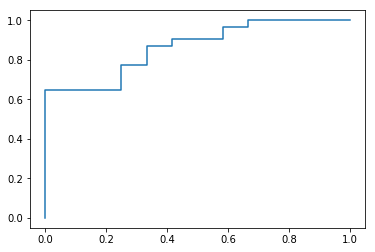

In [20]:
plt.plot(fpr, tpr)

In [124]:
pred_proba = pd.DataFrame(logreg.predict_proba(X_test)).loc[:,1]
pred_proba
d = {'probs':pred_proba}
pd.DataFrame(d)

,probs
0,0.076578
1,0.119315
2,0.087344
3,0.070299
4,0.106699
5,0.235065
6,0.101706
7,0.036687
8,0.108779
9,0.578207


In [137]:
fold_df=pd.DataFrame()
al={'probs':pred_proba, 'labels':y_test.reset_index(drop=True), 't':0}
bl={'probs':pred_proba, 'labels':y_test.reset_index(drop=True), 't':1}
tmpdf = pd.DataFrame(al)
pd.concat([fold_df,tmpdf])

,labels,probs,t
0,0,0.076578,0
1,0,0.119315,0
2,0,0.087344,0
3,0,0.070299,0
4,0,0.106699,0
5,0,0.235065,0
6,0,0.101706,0
7,0,0.036687,0
8,0,0.108779,0
9,0,0.578207,0


In [ ]:
name = '/Users/drdj/locdec/data/mismatch_old_ec109.csv'

In [ ]:
name.split('_')[0].split('/')

In [ ]:
[np.arange(4,8), np.arange(8,13)]

In [85]:
import matplotlib.pyplot as plt

(array([ 9.,  1.,  2.,  1.,  2.,  3.,  2.,  2.,  1., 20.]),
 array([0.03668685, 0.13289307, 0.2290993 , 0.32530552, 0.42151174,
        0.51771796, 0.61392419, 0.71013041, 0.80633663, 0.90254285,
        0.99874908]),
 <a list of 10 Patch objects>)

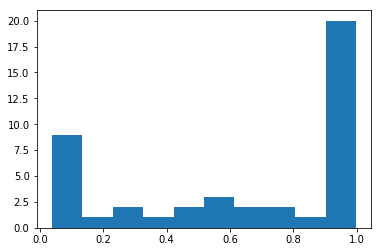

In [91]:
plt.hist(pred_proba['class_1'], bins=20, )

In [122]:
p = (np.sum(.9>pred_proba['class_1'])+1)/(pred_proba.shape[0]+1)
p.dtype

dtype('float64')

In [102]:
pred_proba.shape[0]

43

In [117]:
ilist=[]
for i in range(0,10):
    idict = {'i':i, 'num':'x'}
    ilist.append(idict)
print(ilist)

[{'i': 0, 'num': 'x'}, {'i': 1, 'num': 'x'}, {'i': 2, 'num': 'x'}, {'i': 3, 'num': 'x'}, {'i': 4, 'num': 'x'}, {'i': 5, 'num': 'x'}, {'i': 6, 'num': 'x'}, {'i': 7, 'num': 'x'}, {'i': 8, 'num': 'x'}, {'i': 9, 'num': 'x'}]


In [118]:
pd.DataFrame(ilist)

,i,num
0,0,x
1,1,x
2,2,x
3,3,x
4,4,x
5,5,x
6,6,x
7,7,x
8,8,x
9,9,x


In [119]:
pd.read_csv('ec109mismatch_oldmatch_oldscores.csv')

,Unnamed: 0,auc_z,endfreq,endtime,nperms,pvalue,real_auc,startfreq,starttime,sub
0,0,0 6.61861\ndtype: float64,5,120,100,0.0,0.794667,2,0,ec109
1,1,0 7.030477\ndtype: float64,5,245,100,0.0,0.823200,2,125,ec109
2,2,0 6.67208\ndtype: float64,5,490,100,0.0,0.778792,2,250,ec109
3,3,0 6.052613\ndtype: float64,9,120,100,0.0,0.782320,6,0,ec109
4,4,0 6.647311\ndtype: float64,9,245,100,0.0,0.764163,6,125,ec109
5,5,0 6.29238\ndtype: float64,9,490,100,0.0,0.785225,6,250,ec109


In [18]:
freqs = np.logspace(np.log10(3),np.log10(100),num=50)
freqs_ind = np.arange(1,51)
freqs_ind

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [25]:
fr = pd.DataFrame(freqs_ind, columns=['ind'])

In [61]:
freqs = pd.DataFrame(np.logspace(np.log10(3),np.log10(100),num=50), index=np.arange(1,51), columns=['freqs'])
inds = fr[(fr['freqs']>=3) & (fr['freqs']<=7)].index.values


In [76]:
freq_range=[(3,8), (8,15), (15,25), (25,60), (60,101)]

In [73]:
freqs

,freqs
1,3.000000
2,3.222556
3,3.461621
4,3.718422
5,3.994274
6,4.290590
7,4.608889
8,4.950800
9,5.318076
10,5.712598


In [72]:
for count in range(len(x)):
    print(freqs[(freqs['freqs'] >= freq_range[count][0]) & (freqs['freqs'] <= freq_range[count][1])].index.values)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29 30]
[31 32 33 34 35 36 37 38 39 40 41 42]
[43 44 45 46 47 48 49 50]


In [78]:
freq_idx = [freqs[(freqs['freqs'] >= freq_range[count][0]) & (freqs['freqs'] <= freq_range[count][1])].index.values
 for count in range(len(freq_range))]

In [79]:
freq_idx[0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [97]:
len(range(-750,-500))

250

In [98]:
time_range = [(-750,-500), (-500,-250), (-250,0), (0,250), (250,500), (500,750)]

In [104]:
times = pd.DataFrame(np.arange(-750,751,step=2),index=np.arange(1,752), columns=['time'])

In [105]:
time_idx = [times[(times['time'] >= time_range[count][0]) & (times['time'] <= time_range[count][1])].index.values
 for count in range(len(time_range))]

In [110]:
t = time_idx[0]

In [114]:
t

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126])

In [115]:
times.loc[t[-1]]

time   -500
Name: 126, dtype: int64

In [117]:
for subject in ['ec109']:
    print(subject)

ec109


In [120]:
times = pd.DataFrame(np.arange(-750,751,step=2),index=np.arange(1,752), columns=['time'])

In [121]:
times.loc[t[0]]

time   -750
Name: 1, dtype: int64

In [123]:
100000*1.587

158700.0